In [1]:
import numpy as np
import ufl
from mpi4py import MPI
from petsc4py import PETSc
from slepc4py import SLEPc
import pyvista as pv
from dolfinx import mesh, fem, plot

Create domain! A rectangle (1x2) with 50 elements in each direction

In [2]:
domain = mesh.create_rectangle(comm=MPI.COMM_WORLD, points=[(0, 0), (2, 2)], n=(50, 50))
domain

create function space

In [3]:
V = fem.functionspace(domain, ("Lagrange", 1))

In [4]:
# 2. Apply Dirichlet BC: u = 0 on boundary ∂Ω
def boundary(x):
    return np.isclose(x[0], 0.0) | np.isclose(x[0], 2.0) | np.isclose(x[1], 0.0) | np.isclose(x[1], 2.0)

In [5]:
#Neumann conditions are considered by default
# facets = mesh.locate_entities_boundary(domain, domain.topology.dim - 1, boundary)
# dofs = fem.locate_dofs_topological(V, domain.topology.dim - 1, facets)
# bc = fem.dirichletbc(PETSc.ScalarType(0), dofs, V) # drichlet boundary conditions

In [6]:
# 3. Define bilinear and linear forms
u, v = ufl.TrialFunction(V), ufl.TestFunction(V)
a = fem.form(ufl.inner(ufl.grad(u), ufl.grad(v)) * ufl.dx)
m = fem.form(ufl.inner(u, v) * ufl.dx)

In [7]:
import dolfinx.fem.petsc
# 4. Assemble matrices A and M
A = fem.petsc.assemble_matrix(a, bcs=[])
A.assemble()
M = fem.petsc.assemble_matrix(m, bcs=[])
M.assemble()

In [8]:
# 5. Solve the generalized eigenvalue problem A u = λ M u
eigensolver = SLEPc.EPS().create()
eigensolver.setOperators(A, M)
# eigensolver.setProblemType(SLEPc.EPS.ProblemType.HEP)
eigensolver.setProblemType(SLEPc.EPS.ProblemType.GHEP)
eigensolver.setWhichEigenpairs(2) # set 1 for maximum eigenvalues
eigensolver.setDimensions(nev=7)  # Get 10 eigenvalues
eigensolver.setFromOptions()
eigensolver.solve()

n_conv = eigensolver.getConverged()
if MPI.COMM_WORLD.rank == 0:
    print(f"Number of converged eigenvalues: {n_conv}")


Number of converged eigenvalues: 9


In [9]:
import matplotlib.pyplot as plt
import numpy as np
import dolfinx.plot

def plot_eigenfunctions(domain, V, eigensolver, A, n_conv, nev_to_plot=6):
    """
    Plot the first few eigenfunctions for any given domain using matplotlib.
    Parameters:
        domain: dolfinx.mesh.Mesh
        V: dolfinx.fem.FunctionSpace
        eigensolver: SLEPc.EPS
        A: PETSc.Mat (needed for getVecs)
        n_conv: int (number of converged eigenpairs)
        nev_to_plot: int (number of eigenfunctions to plot)
    """
    if MPI.COMM_WORLD.rank != 0:
        return

    topology, cell_types, geometry = dolfinx.plot.vtk_mesh(domain)
    points = geometry

    # Set up grid for plotting multiple eigenfunctions
    nrows = int(np.ceil(np.sqrt(nev_to_plot)))
    ncols = int(np.ceil(nev_to_plot / nrows))
    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows))
    axes = axes.flatten()

    for i in range(min(nev_to_plot, n_conv)):
        eigval = eigensolver.getEigenvalue(i)
        error = eigensolver.computeError(i)
        print(f"Eigenvalue {i}: {eigval.real:.4f} (Error: {error:.2e})")

        r, _ = A.getVecs()
        eigensolver.getEigenvector(i, r)
        uh = fem.Function(V)
        uh.x.petsc_vec.array = r.array
        uh.x.petsc_vec.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)

        # Plot using matplotlib's tricontourf for smooth color
        ax = axes[i]
        tcf = ax.tricontourf(points[:, 0], points[:, 1], uh.x.array.real, levels=50, cmap='jet')
        ax.set_title(f"Eigenfunction {i}\n$\lambda$ = {eigval.real:.4f}", fontsize=12)
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_aspect('equal')
        fig.colorbar(tcf, ax=ax, orientation='vertical', shrink=0.8)

    # Hide unused subplots
    for j in range(i + 1, nrows * ncols):
        fig.delaxes(axes[j])

    plt.suptitle("Laplace Eigenfunctions", fontsize=16, weight='hsv')
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

# Usage example (after solving eigenproblem):
# plot_eigenfunctions(domain, V, eigensolver, A, n_conv, nev_to_plot=6)


Eigenvalue 0: -0.0000 (Error: 4.13e+11)
Eigenvalue 1: 2.4682 (Error: 2.54e-08)
Eigenvalue 2: 2.4682 (Error: 1.52e-11)
Eigenvalue 3: 4.9397 (Error: 1.65e-08)
Eigenvalue 4: 9.8826 (Error: 1.09e-12)
Eigenvalue 5: 9.8826 (Error: 1.12e-12)
Eigenvalue 6: 12.3579 (Error: 7.11e-13)
Eigenvalue 7: 12.3696 (Error: 7.29e-13)
Eigenvalue 8: 19.8170 (Error: 4.72e-13)


ValueError: weight='hsv' is invalid

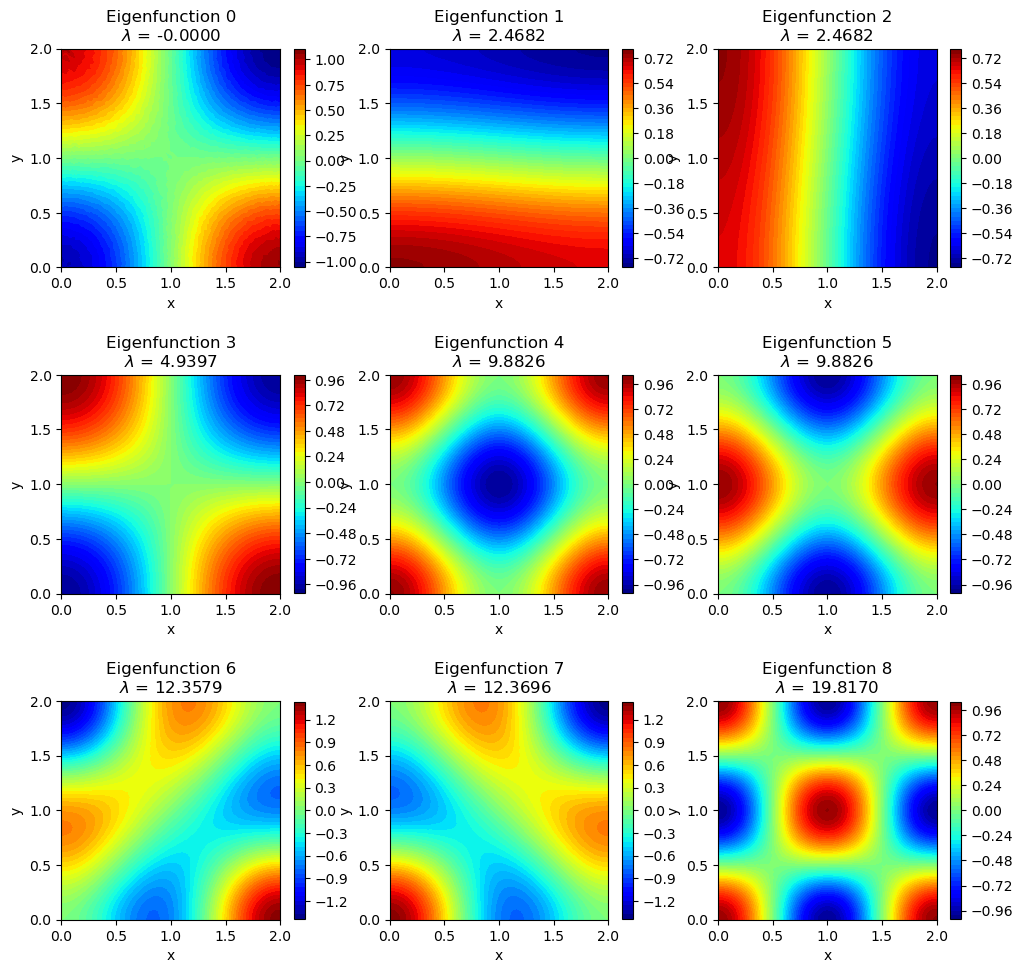

In [10]:
plot_eigenfunctions(domain, V, eigensolver, A, n_conv, nev_to_plot=n_conv)

In [ ]:
# # 6. Extract and plot first few eigenfunctions
# if MPI.COMM_WORLD.rank == 0:
#     topology, cell_types, geometry = plot.vtk_mesh(V)
#     points = domain.geometry.x
#     for i in range(min(n_conv, 10)):
#         eigval = eigensolver.getEigenvalue(i)
#         print(f"Eigenvalue {i}: {eigval:.4f}")

#         r, _ = A.getVecs()
#         eigensolver.getEigenvector(i, r)

#         uh = fem.Function(V)
#         uh.x.petsc_vec.setArray(r.array)
#         uh.x.petsc_vec.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)

#         # Create PyVista grid
#         values = uh.x.array.real
#         grid = pv.UnstructuredGrid(topology, cell_types, points)
#         grid.point_data["u"] = values

#         # Plot
#         plotter = pv.Plotter()
#         plotter.add_mesh(grid, show_edges=True, scalars="u", cmap="hsv")
#         plotter.view_xy()
#         plotter.add_text(f"Eigenfunction {i}, λ = {eigval:.2f}", font_size=12)
#         plotter.show(interactive=True)


Eigenvalue 0: -0.0000


Widget(value='<iframe src="http://localhost:44779/index.html?ui=P_0x74c6025917f0_0&reconnect=auto" class="pyvi…

Eigenvalue 1: 2.4682


Widget(value='<iframe src="http://localhost:44779/index.html?ui=P_0x74c5f4d6f9d0_1&reconnect=auto" class="pyvi…

Eigenvalue 2: 2.4682


Widget(value='<iframe src="http://localhost:44779/index.html?ui=P_0x74c5f4d6f890_2&reconnect=auto" class="pyvi…

Eigenvalue 3: 4.9397


Widget(value='<iframe src="http://localhost:44779/index.html?ui=P_0x74c5f4cc4e10_3&reconnect=auto" class="pyvi…

Eigenvalue 4: 9.8826


Widget(value='<iframe src="http://localhost:44779/index.html?ui=P_0x74c5f4cc5f90_4&reconnect=auto" class="pyvi…

Eigenvalue 5: 9.8826


Widget(value='<iframe src="http://localhost:44779/index.html?ui=P_0x74c5f4cc60d0_5&reconnect=auto" class="pyvi…

Eigenvalue 6: 12.3579


Widget(value='<iframe src="http://localhost:44779/index.html?ui=P_0x74c5f4cc6210_6&reconnect=auto" class="pyvi…

Eigenvalue 7: 12.3696


Widget(value='<iframe src="http://localhost:44779/index.html?ui=P_0x74c5f4cc6350_7&reconnect=auto" class="pyvi…

Eigenvalue 8: 19.8170


Widget(value='<iframe src="http://localhost:44779/index.html?ui=P_0x74c5f4cc6490_8&reconnect=auto" class="pyvi…